# Librerías

In [1]:
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Creamos el DataFrame

## Descargamos el json

Para eso leemos el archivo output_steam_games.json con la libreria json y lo convertimos en un DataFrame de pandas para poder manejarlo

In [2]:
output_sg = []
with open('output_steam_games.json', 'r') as file:
    for line in file:
        k = json.loads(line)
        output_sg.append(k)

steam_games_original = pd.DataFrame(output_sg)

Creamos una copia para poder manejarla con mayor tranquilidad y por cualquier error no tener que descargar nuevamente los datos

In [3]:
steam_games = steam_games_original.copy()

Hacemos una primera revision de los datos, para saber cantidad de registros y datos vacíos.

In [4]:
print(f'Formato del DataFrame: {steam_games.shape}')
steam_games.info()

Formato del DataFrame: (120445, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


In [5]:
steam_games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nos damos cuenta que los primeros 88310 registros de la tabla no tienen ninguna información, por lo que decidimos eliminarlos.
Luego reseteamos el index para dejar prolijo el DataFrame.

In [6]:
steam_games.drop(index=steam_games.index[:88310], inplace=True)

steam_games.reset_index(drop=True, inplace=True)

In [7]:
print(f'Formato del DataFrame: {steam_games.shape}')
steam_games.info()

Formato del DataFrame: (32135, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 3.2+ MB


In [8]:
steam_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL


Eliminamos las columnas innecesarias para este proyecto

In [9]:
steam_games.drop(columns=['publisher','app_name','url','tags','reviews_url','specs','early_access'], inplace=True)

In [10]:
steam_games.head(2)

,genres,title,release_date,price,id,developer
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,4.99,761140,Kotoshiro
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,Free To Play,643980,Secret Level SRL


Reordenamos las columnas

In [11]:
steam_games = steam_games[['id', 'developer', 'title', 'genres', 'release_date', 'price']]

Le cambiamos el nombre a la columna id para estandarizar

In [12]:
steam_games = steam_games.rename(columns={'id':'item_id'})

# Columna release_date

Para este proyecto nos interesa unicamente el dato del anio de lanzamiento. Por esto, creamos una funcion que al ingresar la columna me devuelva una lista de valores con los primeros 4 digitos (correspondientes al anio). En caso de que no encuentre esos 4 digitos devuelve NaN.

In [13]:
def extraccion_anio(columna):
    # Lista para almacenar los resultados procesados
    resultados = []
    
    for line in columna:
        if isinstance(line, str) and line[:4].isdigit():
            # Si comienza con 4 números consecutivos, dejar solo esos números
            resultados.append(int(line[:4]))
        else:
            # Si no comienza con 4 números consecutivos, transformar en NaN
            resultados.append(np.nan)
    
    return resultados

Pasamos la columna release_date por la funcion y que nos devuelva los valores en una nueva columna llamada release_year.
Como solo necesitamos el anio, eliminamos entonces la columna release_date.

In [14]:
steam_games['release_year'] = extraccion_anio(steam_games['release_date'])
steam_games = steam_games.drop(columns=['release_date'], axis=1)

In [15]:
steam_games.head(2)

,item_id,developer,title,genres,price,release_year
0,761140,Kotoshiro,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",4.99,2018.0
1,643980,Secret Level SRL,Ironbound,"[Free to Play, Indie, RPG, Strategy]",Free To Play,2018.0


# Columna item_id

Examinamos si hay datos vacios y duplicados en el DataFrame

## Vacios

In [16]:
id_vacios = steam_games[steam_games['item_id'].isna()]
id_vacios

,item_id,developer,title,genres,price,release_year
74,NaN,NaN,NaN,NaN,19.99,NaN
30961,NaN,"Rocksteady Studios,Feral Interactive (Mac)",Batman: Arkham City - Game of the Year Edition,"[Action, Adventure]",19.99,2012.0


El registro Nro 74 no tiene informacion en casi ninguna columna por lo que no nos suma valor, decidimos eliminarla.

In [17]:
steam_games.drop(index=steam_games.index[74], inplace=True)

Revisamos si el registro 30961 no esta repetido dentro del DataFrame segun el titulo del juego

In [18]:
steam_games[steam_games['title'] == 'Batman: Arkham City - Game of the Year Edition']

,item_id,developer,title,genres,price,release_year
1068,200260,"Rocksteady Studios,Feral Interactive (Mac)",Batman: Arkham City - Game of the Year Edition,"[Action, Adventure]",19.99,2012.0
30961,NaN,"Rocksteady Studios,Feral Interactive (Mac)",Batman: Arkham City - Game of the Year Edition,"[Action, Adventure]",19.99,2012.0


Como vemos que ya hay un registro exactamente igual, decidimos eliminarlo. (Como ya eliminamos un registro anterior, tomamos el numero de indice 30960)

In [19]:
steam_games.drop(index=steam_games.index[30960], inplace=True)

## Duplicados

In [20]:
id_duplicados = steam_games[steam_games.duplicated(subset='item_id', keep=False)]
id_duplicados

,item_id,developer,title,genres,price,release_year
13894,612880,Machine Games,Wolfenstein II: The New Colossus,[Action],59.99,2017.0
14573,612880,Machine Games,Wolfenstein II: The New Colossus,[Action],59.99,2017.0


Vemos que hay un registro repetido por lo que decidimos eliminar uno de ellos

In [21]:
steam_games.drop(index=steam_games.index[13894], inplace=True)

## Reindexamos

In [22]:
steam_games.reset_index(drop=True, inplace=True)

In [23]:
print(f'Formato del DataFrame: {steam_games.shape}')

Formato del DataFrame: (32132, 6)


In [24]:
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32132 entries, 0 to 32131
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       32132 non-null  object 
 1   developer     28835 non-null  object 
 2   title         30084 non-null  object 
 3   genres        28851 non-null  object 
 4   price         30755 non-null  object 
 5   release_year  29830 non-null  float64
dtypes: float64(1), object(5)
memory usage: 1.5+ MB


# Columna developer

## Vacios

In [25]:
dev_vacios = steam_games[steam_games['developer'].isna()]
dev_vacios

,item_id,developer,title,genres,price,release_year
4,773570,NaN,NaN,NaN,2.99,NaN
11,724910,NaN,NaN,NaN,Free,NaN
19,772590,NaN,NaN,NaN,4.99,NaN
20,640250,NaN,NaN,NaN,2.99,NaN
22,711440,NaN,NaN,NaN,0.99,NaN
...,...,...,...,...,...,...
32115,775640,NaN,Robotpencil Presents: Exercise: Brushwork,NaN,3.99,2018.0
32116,777930,NaN,Robotpencil Presents: Creative Composition,NaN,3.99,2018.0
32117,775370,NaN,The Gamble House,NaN,4.99,2016.0
32118,777950,NaN,Kalen Chock Presents: 2017 Free Tutorial,NaN,Free,2018.0


En principio decidimos dejar los registros vacios ya que pueden proporcionar otro tipo de información de valor para diferentes consultas. 

## Grafico de barras

Realizamos un grafico de barras del top 10 de desarrolladores con mas juegos y la cantidad de cada uno.

In [60]:
# Agrupamos el DataFrame por el nombre del desarrollador y contamos la cantidad de juegos para cada uno
juegos_por_desarrollador = steam_games['developer'].value_counts()
juegos_por_desarrollador

developer
Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
                              ... 
Royal9Games,RoyalJL              1
Salus Games                      1
Class of  2016-2017              1
Pirotexnik                       1
Bidoniera Games                  1
Name: count, Length: 10992, dtype: int64

In [62]:
# Filtramos el top 10 de desarrolladores
juegos_por_desarrollador = juegos_por_desarrollador.head(10)

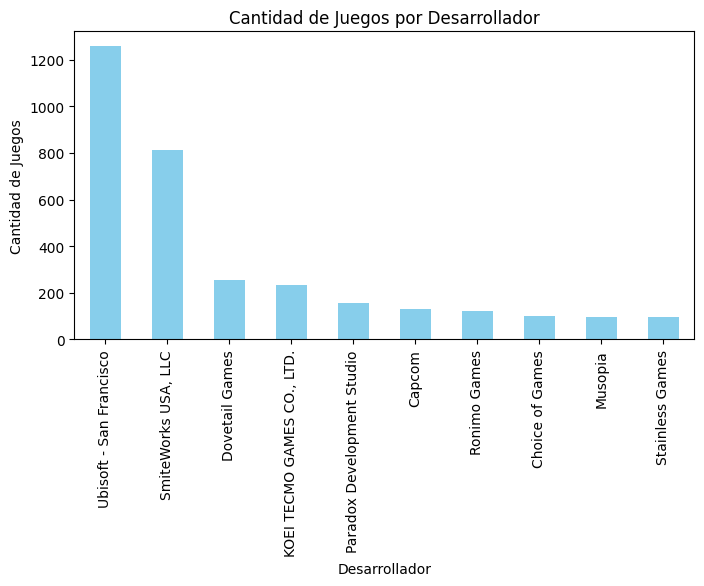

In [64]:
# Creamos el gráfico de barras
plt.figure(figsize=(8, 4))
juegos_por_desarrollador.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Juegos por Desarrollador')
plt.xlabel('Desarrollador')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=90)

plt.show()

# Columnas genres

## Vacios

In [26]:
genres_vacios = steam_games[steam_games['genres'].isna()]
genres_vacios

,item_id,developer,title,genres,price,release_year
4,773570,NaN,NaN,NaN,2.99,NaN
11,724910,NaN,NaN,NaN,Free,NaN
19,772590,NaN,NaN,NaN,4.99,NaN
20,640250,NaN,NaN,NaN,2.99,NaN
22,711440,NaN,NaN,NaN,0.99,NaN
...,...,...,...,...,...,...
32115,775640,NaN,Robotpencil Presents: Exercise: Brushwork,NaN,3.99,2018.0
32116,777930,NaN,Robotpencil Presents: Creative Composition,NaN,3.99,2018.0
32117,775370,NaN,The Gamble House,NaN,4.99,2016.0
32118,777950,NaN,Kalen Chock Presents: 2017 Free Tutorial,NaN,Free,2018.0


En principio decidimos dejar los registros vacios ya que pueden proporcionar otro tipo de información de valor para diferentes consultas. 

# Columna price

## Vacios

In [27]:
price_vacios = steam_games[steam_games['price'].isna()]
price_vacios

,item_id,developer,title,genres,price,release_year
9,768800,RewindApp,Race,"[Casual, Indie, Racing, Simulation]",NaN,2018.0
10,768570,Qucheza,Uncanny Islands,"[Action, Indie, Simulation, Early Access]",NaN,NaN
31,520680,BlueLine Games,Lost Cities,"[Casual, Indie, Strategy]",NaN,2018.0
32,690410,Games by Brundle,Twisted Enhanced Edition,[Action],NaN,2018.0
34,413120,ProjectorGames,Tactics Forever,"[Action, Casual, Indie, Massively Multiplayer,...",NaN,2018.0
...,...,...,...,...,...,...
32096,771070,Picorinne Soft,Infinos Gaiden,"[Action, Indie]",NaN,2018.0
32108,90007,I.O.S. Team,International Online Soccer,[Sports],NaN,2002.0
32120,772180,VersoVR,Cricket Club,"[Casual, Indie, Simulation, Sports, Early Access]",NaN,NaN
32122,771810,Retro Army Limited,The spy who shot me™,"[Action, Adventure, Indie]",NaN,2018.0


Decidimos reemplazar los valores NaN por el valor 0.00 para poder realizar los calculos correspondientes en cada consulta.

In [28]:
steam_games['price'] = steam_games['price'].fillna('0.00')

Revisamos los valores de la columna para ver que otras modificaciones debemos realizar

In [29]:
steam_games['price'].unique()

array([4.99, 'Free To Play', 'Free to Play', 0.99, 2.99, 3.99, 9.99,
       18.99, 29.99, '0.00', 'Free', 10.99, 1.59, 14.99, 1.99, 59.99,
       8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 12.99, 5.99, 2.49, 15.99,
       1.25, 24.99, 17.99, 61.99, 3.49, 11.99, 13.99, 'Free Demo',
       'Play for Free!', 34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99,
       16.99, 79.99, 49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99,
       149.99, 771.71, 'Install Now', 21.99, 89.99,
       'Play WARMACHINE: Tactics Demo', 0.98, 139.92, 4.29, 64.99,
       'Free Mod', 54.99, 74.99, 'Install Theme', 0.89, 'Third-party',
       0.5, 'Play Now', 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99,
       10.93, 1.39, 'Free HITMAN™ Holiday Pack', 36.99, 4.49, 2.0, 4.0,
       9.0, 234.99, 1.95, 1.5, 199.0, 189.0, 6.66, 27.99, 10.49, 129.99,
       179.0, 26.99, 399.99, 31.99, 399.0, 20.0, 40.0, 3.33, 199.99,
       22.99, 320.0, 38.85, 71.7, 59.95, 995.0, 27.49, 3.39, 6.0, 19.95,
       499.99, 16.06, 4.68, 

Vemos algunas categorias a modificar, por ejemplo:

- Juegos gratuitos con los valores de:
    - 'Free To Play'
    - 'Free'
    - 'Free Demo'
    - 'Free Mod'
    - 'Free HITMAN™ Holiday Pack'
    - 'Free to Try'
    - 'Free Movie'
    - 'Free to Use'
    - 'Play WARMACHINE: Tactics Demo'
    - 'Play the Demo'

Vemos que las palabras que se repiten son 'Free' y 'Demo' por lo que decidimos crear una funcion para que me reemplace los valores por 0.00, ademas, modficamos los valores que tengan palabras y numeros para extraer unicamente la parte numerica.

Por ultimo, hay 3 categorias

- 'Install Now'
- 'Play Now'
- 'Install Theme'

que tambien decidimos reemplazar por 0.00

In [30]:
# Definimos la función para reemplazar palabras por cero
def reemplazar_palabras_por_cero(valor):
    if isinstance(valor, str):
        # Reemplaza 'Free' y 'Demo' por '0.00'
        if 'Free' in valor or 'Demo' in valor or 'Install' in valor or 'Now' in valor:
            return '0.00'
        
        # Utiliza una expresión regular para extraer valores numéricos de las cadenas
        match = re.search(r'\d+\.\d{2}', valor)
        if match:
            return match.group()
    
    return valor

steam_games['price'] = steam_games['price'].apply(reemplazar_palabras_por_cero)

In [31]:
steam_games['price'].unique()

array([4.99, '0.00', 0.99, 2.99, 3.99, 9.99, 18.99, 29.99, 10.99, 1.59,
       14.99, 1.99, 59.99, 8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 12.99,
       5.99, 2.49, 15.99, 1.25, 24.99, 17.99, 61.99, 3.49, 11.99, 13.99,
       34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99, 16.99, 79.99,
       49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99, 149.99, 771.71,
       21.99, 89.99, 0.98, 139.92, 4.29, 64.99, 54.99, 74.99, 0.89,
       'Third-party', 0.5, 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0,
       20.99, 10.93, 1.39, 36.99, 4.49, 2.0, 4.0, 9.0, 234.99, 1.95, 1.5,
       199.0, 189.0, 6.66, 27.99, 10.49, 129.99, 179.0, 26.99, 399.99,
       31.99, 399.0, 20.0, 40.0, 3.33, 199.99, 22.99, 320.0, 38.85, 71.7,
       59.95, 995.0, 27.49, 3.39, 6.0, 19.95, 499.99, 16.06, 4.68, 131.4,
       44.98, 202.76, 1.0, 2.3, 0.95, 172.24, 249.99, 2.97, 10.96, 10.0,
       30.0, 2.66, 6.48, 19.29, 11.15, 18.9, 2.89, 99.0, 87.94, 599.0,
       8.98, 9.69, 0.49, 9.98, 9.95, 7.0, '499.00', '449.00', 12.8

Por ultimo, revisamos el valor 'Third-party' para ver que hacer con ese registro.

In [32]:
steam_games[steam_games['price'] == 'Third-party']

,item_id,developer,title,genres,price,release_year
3917,362970,Polar Bunny Ltd,Parcel - Soundtrack,[Indie],Third-party,2015.0
31835,3483,"PopCap Games, Inc.",Peggle Extreme,[Casual],Third-party,2007.0


Vemos que son solo 2 registros, y que se refieren a que son items manejados por otra empresa, por lo que decidimos eliminarlos de nuestro dataset.

In [33]:
steam_games = steam_games.drop(steam_games[steam_games['price'] == 'Third-party'].index)

In [34]:
steam_games.price.unique()

array([4.99, '0.00', 0.99, 2.99, 3.99, 9.99, 18.99, 29.99, 10.99, 1.59,
       14.99, 1.99, 59.99, 8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 12.99,
       5.99, 2.49, 15.99, 1.25, 24.99, 17.99, 61.99, 3.49, 11.99, 13.99,
       34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99, 16.99, 79.99,
       49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99, 149.99, 771.71,
       21.99, 89.99, 0.98, 139.92, 4.29, 64.99, 54.99, 74.99, 0.89, 0.5,
       299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99, 10.93, 1.39,
       36.99, 4.49, 2.0, 4.0, 9.0, 234.99, 1.95, 1.5, 199.0, 189.0, 6.66,
       27.99, 10.49, 129.99, 179.0, 26.99, 399.99, 31.99, 399.0, 20.0,
       40.0, 3.33, 199.99, 22.99, 320.0, 38.85, 71.7, 59.95, 995.0, 27.49,
       3.39, 6.0, 19.95, 499.99, 16.06, 4.68, 131.4, 44.98, 202.76, 1.0,
       2.3, 0.95, 172.24, 249.99, 2.97, 10.96, 10.0, 30.0, 2.66, 6.48,
       19.29, 11.15, 18.9, 2.89, 99.0, 87.94, 599.0, 8.98, 9.69, 0.49,
       9.98, 9.95, 7.0, '499.00', '449.00', 12.89, 6.49, 1.87, 

### Modificamos el tipo de dato por float

In [35]:
steam_games['price'] = steam_games['price'].astype(float)

In [36]:
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32130 entries, 0 to 32131
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       32130 non-null  object 
 1   developer     28833 non-null  object 
 2   title         30082 non-null  object 
 3   genres        28849 non-null  object 
 4   price         32130 non-null  float64
 5   release_year  29828 non-null  float64
dtypes: float64(2), object(4)
memory usage: 1.7+ MB


## Outliers

Realizamos un grafico de boxplot para verificar si existen outliers en la columna price

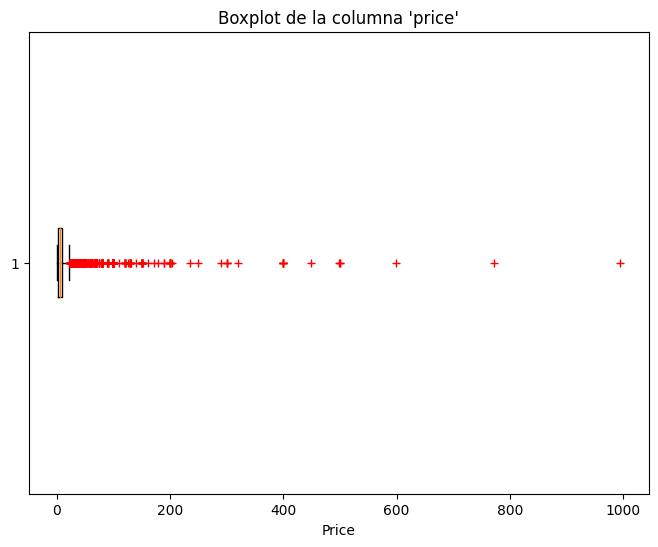

In [37]:
plt.figure(figsize=(8, 6))
plt.boxplot(steam_games['price'], vert=False, sym='r+')
plt.title("Boxplot de la columna 'price'")
plt.xlabel("Price")
plt.show()

Al detectar que existen outliers, realizamos un grafico de scatter plot para analizarlos un poco mejor.

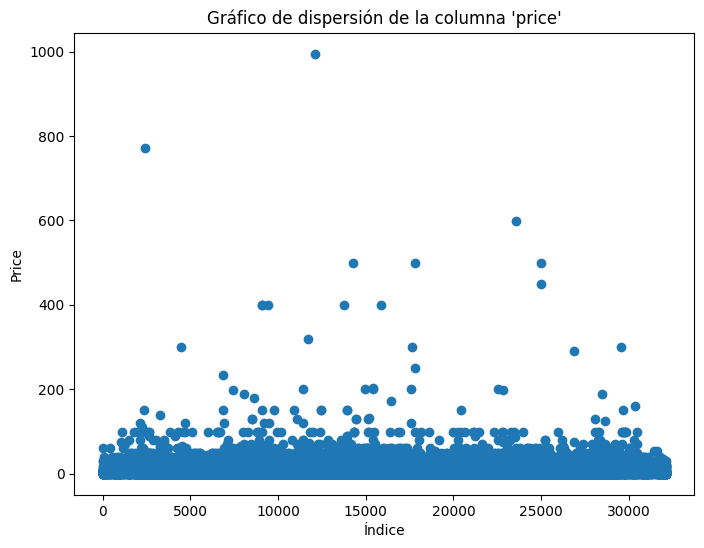

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(steam_games['price'])), steam_games['price'])
plt.title("Gráfico de dispersión de la columna 'price'")
plt.xlabel("Índice")
plt.ylabel("Price")
plt.show()

Filtramos el DataFrame para ver los registros cuyo precio supera los 200 USD

In [39]:
steam_games[steam_games['price'] > 200]

,item_id,developer,title,genres,price,release_year
2391,292180,Laminar Research,X-Plane 10 Global - 64 Bit,[Simulation],771.71,2014.0
4444,401090,The Foundry,MODO indie 10,"[Animation &amp; Modeling, Design &amp; Illust...",299.99,2015.0
6861,377350,Chessbase,ChessBase 13 Pro,NaN,234.99,2016.0
9073,585620,YoYo Games Ltd.,GameMaker Studio 2 Mobile,"[Animation &amp; Modeling, Design &amp; Illust...",399.99,2017.0
9074,585610,YoYo Games Ltd.,GameMaker Studio 2 UWP,"[Animation &amp; Modeling, Design &amp; Illust...",399.99,2017.0
9416,598860,MAGIX Software GmbH,MAGIX Video Pro X8 Steam Edition,[Video Production],399.00,2017.0
11734,707410,CLO Virtual Fashion,Marvelous Designer 7 For Steam,"[Animation &amp; Modeling, Design &amp; Illust...",320.00,2017.0
12087,719000,"Strata Mixed Reality, Inc.",Strata Spaces VR – Professional Edition Upgrade,"[Animation &amp; Modeling, Design &amp; Illust...",995.00,2017.0
13754,750840,MAGIX Software GmbH,MAGIX Video Pro X9 Steam Edition,[Video Production],399.00,2017.0
14302,691560,RUHRSOURCE GmbH,CUR3D Maker Edition - Permission for commercia...,"[Animation &amp; Modeling, Design &amp; Illust...",499.99,2017.0


No vemos que sean errores sino simplemente items cuyo valor es mas alto, por lo que decidimos mantenerlos en nuestro dataset

## Grafico de torta

Realizamos un grafico de torta para visualizar la diferencia entre la cantidad de juegos pagos vs la cantidad de juegos gratuitos que tiene la plataforma.

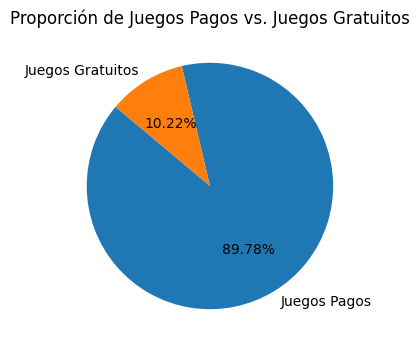

In [54]:
# Contar la cantidad de juegos con precio (no gratuitos) y juegos gratuitos
cantidad_pagos = len(steam_games[steam_games['price'] != 0.00])
cantidad_gratuitos = len(steam_games[steam_games['price'] == 0.00])

# Etiquetas para las categorías
categorias = ['Juegos Pagos', 'Juegos Gratuitos']

# Datos de cada categoría
datos = [cantidad_pagos, cantidad_gratuitos]

# Crea el gráfico circular
plt.figure(figsize=(4, 4))
plt.pie(datos, labels=categorias, autopct='%1.2f%%', startangle=140)
plt.title('Proporción de Juegos Pagos vs. Juegos Gratuitos')

plt.show()


# Columna release_year

## Vacios

In [86]:
steam_games[steam_games['release_year'].isnull()]

,item_id,developer,title,genres,price,release_year
4,773570,NaN,NaN,NaN,2.99,NaN
10,768570,Qucheza,Uncanny Islands,"[Action, Indie, Simulation, Early Access]",0.00,NaN
11,724910,NaN,NaN,NaN,0.00,NaN
19,772590,NaN,NaN,NaN,4.99,NaN
20,640250,NaN,NaN,NaN,2.99,NaN
...,...,...,...,...,...,...
32081,755540,NaN,NaN,NaN,0.00,NaN
32083,755830,"Greyson Richey,Nicholas Lives",Lonely Astronaut,"[Action, Casual, Indie, Simulation]",0.00,NaN
32084,708070,rechargecomplete,RECHARGE COMPLETE,"[Action, Adventure, Indie, Early Access]",0.00,NaN
32119,772180,VersoVR,Cricket Club,"[Casual, Indie, Simulation, Sports, Early Access]",0.00,NaN


Por el momento decidimos no modificar esos registros ya que muchos nos aportan otra informacion de valor. 

## Grafico de barras 

Creamos un grafico de barras para visualizar la cantidad de juegos lanzados por anio

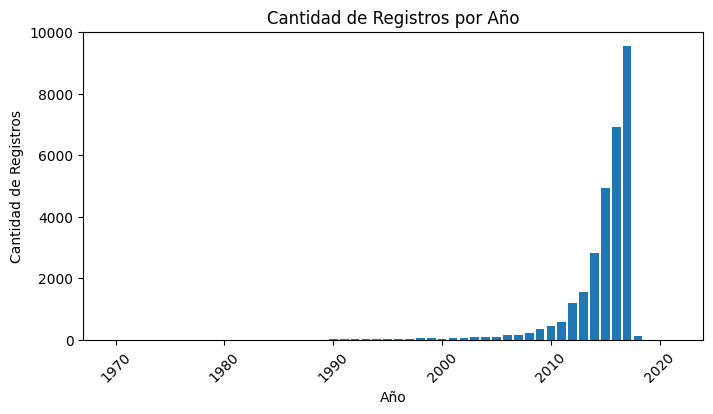

In [56]:
conteo_por_anio = steam_games['release_year'].value_counts().sort_index()

# Crea el gráfico de barras
plt.figure(figsize=(8, 4))
plt.bar(conteo_por_anio.index, conteo_por_anio.values)
plt.xlabel('Año')
plt.ylabel('Cantidad de Registros')
plt.title('Cantidad de Registros por Año')
plt.xticks(rotation=45) 

plt.show()

# Descargamos el csv

In [87]:
steam_games.to_csv('steam_games.csv', index=False)